# 📊 EDA — Interim Stage  
*Financial-News Sentiment Project* — **June 2025**

This notebook analyses the system as it stands at the interim milestone:

* **Corpora:** 100 k raw articles, 500-doc gold-standard v1.  
* **Pipelines compared:**  
  1. **VADER baseline** → `processed_articles_vader.jsonl`  
  2. **FinBERT standard** → `processed_articles_standard.jsonl`  
  3. **FinBERT optimized (current)** → `processed_articles_optimized.jsonl`  

We will inspect class distributions, ticker/sector coverage, per-class metrics,
confusion matrices, calibration, and surface illustrative errors.


In [3]:
# Notebook 0 – Imports & paths
# %pip install --quiet pandas matplotlib seaborn scikit-learn jsonlines numpy

import json, jsonlines, re, textwrap, warnings
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
warnings.filterwarnings("ignore")

DATA_DIR     = Path("../data")
PLOTS_DIR    = DATA_DIR / "plots"
PLOTS_DIR.mkdir(exist_ok=True, parents=True)

GOLD_FILE    = DATA_DIR / "gold_standard_annotations.jsonl"
PIPE_FILES   = {
    "VADER"    : DATA_DIR / "vader_baseline_results.jsonl",
    "FinBERT Std": DATA_DIR / "processed_articles_standard.jsonl",
    "FinBERT Opt": DATA_DIR / "processed_articles_optimized.jsonl",
}
EVAL_JSON    = DATA_DIR / "evaluation_results.json"   # produced by comprehensive_evaluation.py
assert GOLD_FILE.exists() and all(p.exists() for p in PIPE_FILES.values()), "Missing input files"


## 1  Gold-standard overview


In [4]:
gold_df = pd.read_json(GOLD_FILE, lines=True)
print(f"Gold docs: {len(gold_df):,}")
gold_df.head(2)


Gold docs: 1,000


,overall_sentiment,overall_confidence,overall_rationale,ticker_sentiments,key_sentences,article_hash,title,content,annotator,annotation_timestamp,true_overall,found_tickers
0,Positive,0.95,The article reports significant year-over-year...,"{'PRPH': {'sentiment': 'Positive', 'confidence...",[ProPhase Labs Announces Record Third Quarter ...,6bc576e869822869f9381540bf779756,ProPhase Labs Announces Record Third Quarter 2...,"ProPhase Labs, Inc.\n\nQ3 2022 Net Revenues of...",gpt-4-turbo-preview,2025-06-23T10:45:27.141229,Positive,"[{'symbol': 'NET', 'score': 0.0102378605637110..."
1,Positive,0.95,The article reports on Varonis Systems beating...,"{'VRNS': {'sentiment': 'Positive', 'confidence...",[Varonis Systems (VRNS) came out with quarterl...,194b48fd5ddf94c94cbfc45093ccdcbd,Varonis Systems (VRNS) Q4 Earnings and Revenue...,Varonis Systems (VRNS) came out with quarterly...,gpt-4-turbo-preview,2025-06-23T10:45:35.434763,Positive,"[{'symbol': 'OUT', 'score': 1.0, 'label': 'Pos..."


### 1.1 Class balance within 500-doc gold set


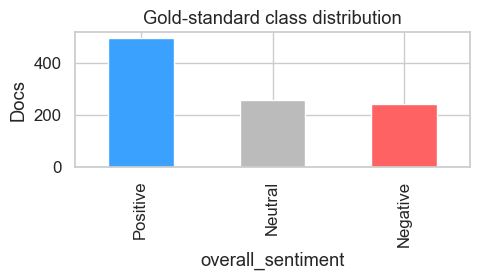

In [5]:
class_counts = gold_df["overall_sentiment"].value_counts().reindex(["Positive","Neutral","Negative"])
class_counts.plot.bar(color=["#3BA1FF","#BBBBBB","#FF6262"], figsize=(5,3))
plt.title("Gold-standard class distribution")
plt.ylabel("Docs"); plt.tight_layout()


### 1.2 Tickers coverage in gold


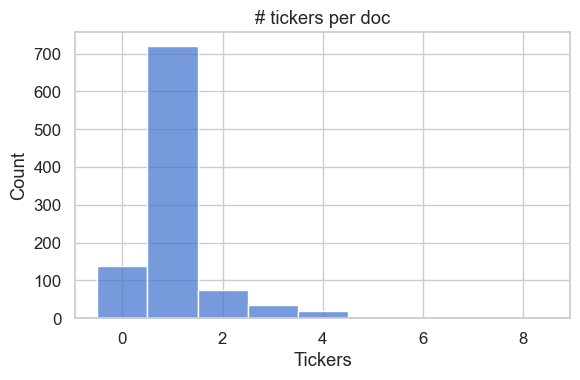

In [14]:
gold_df["n_tickers"] = gold_df["ticker_sentiments"].apply(len)

plt.figure(figsize=(6, 4))
sns.histplot(gold_df["n_tickers"], bins=range(1, 8), discrete=True)
plt.title("# tickers per doc")
plt.xlabel("Tickers")
plt.ylabel("Count")
plt.tight_layout()
plt.tight_layout()


## 2  Load pipeline outputs for comparison


In [15]:
def load_jsonl(path):
    with jsonlines.open(path) as rdr:
        return [r for r in rdr if "_pipeline_name" not in r]  # skip meta line

pipe_outputs = {name: load_jsonl(file) for name, file in PIPE_FILES.items()}
print({k: len(v) for k, v in pipe_outputs.items()})


{'VADER': 59749, 'FinBERT Std': 59749, 'FinBERT Opt': 59749}


### 2.1 Quick coverage check — docs that overlap gold


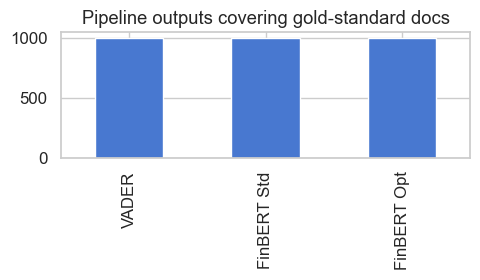

In [16]:
gold_hashes = set(gold_df["article_hash"])
overlap = {k: sum(r["article_hash"] in gold_hashes for r in v) for k,v in pipe_outputs.items()}
pd.Series(overlap, name="Docs w/ gold label").plot.bar(figsize=(5,3))
plt.title("Pipeline outputs covering gold-standard docs")
plt.tight_layout()


## 3  Performance metrics
Load pre-computed `evaluation_results.json` if present; otherwise compute on the fly.


In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, brier_score_loss
from sklearn.calibration import calibration_curve
if EVAL_JSON.exists():
    metrics = json.load(open(EVAL_JSON))
else:
    metrics = {}
    y_true = gold_df["overall_sentiment"].values
    label2id = {"Positive":0,"Neutral":1,"Negative":2}
    for name, preds in pipe_outputs.items():
        pred_map = {r["article_hash"]: r["overall_sentiment"] for r in preds}
        y_pred = [pred_map.get(h, "Neutral") for h in gold_df["article_hash"]]
        acc  = accuracy_score(y_true, y_pred)
        pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=["Positive","Neutral","Negative"], zero_division=0, average=None)
        metrics[name] = {
            "accuracy": acc,
            "per_class": {c: {"precision":p,"recall":r,"f1":f} for c,p,r,f in zip(["Positive","Neutral","Negative"], pr, rc, f1)},
            "confusion_matrix": confusion_matrix(y_true, y_pred, labels=["Positive","Neutral","Negative"]).tolist()
        }
json.dump(metrics, open(EVAL_JSON,"w"), indent=2)
metrics


{'Standard': {'accuracy': 0.645,
  'macro_f1': 0.6473292455142552,
  'precision': 0.6616972145022242,
  'recall': 0.6726440894601756,
  'confusion_matrix': [[285, 172, 38], [33, 173, 50], [8, 49, 187]],
  'n_samples': 1000,
  'ticker_accuracy': 0.5588235294117647,
  'per_class': {'Positive': {'precision': 0.8742331288343558,
    'recall': 0.5757575757575758,
    'f1': 0.6942752740560292},
   'Neutral': {'precision': 0.4357682619647355,
    'recall': 0.67578125,
    'f1': 0.5298621745788668},
   'Negative': {'precision': 0.6750902527075813,
    'recall': 0.7663934426229508,
    'f1': 0.7178502879078695}}},
 'Optimized': {'accuracy': 0.642,
  'macro_f1': 0.6371065851483313,
  'precision': 0.6418793397276095,
  'recall': 0.6629633079428162,
  'confusion_matrix': [[295, 151, 49], [38, 152, 66], [10, 39, 195]],
  'n_samples': 1000,
  'ticker_accuracy': 0.5647058823529412,
  'per_class': {'Positive': {'precision': 0.8600583090379009,
    'recall': 0.5959595959595959,
    'f1': 0.704057279236

### 3.1 Accuracy & macro-F1 bar chart


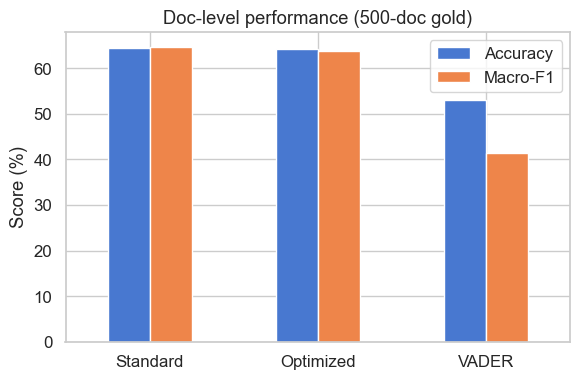

In [19]:
acc = {k: v["accuracy"]*100 for k,v in metrics.items()}
macro = {k: np.mean([v["per_class"][c]["f1"] for c in v["per_class"]])*100 for k,v in metrics.items()}

df_scores = pd.DataFrame({"Accuracy":acc, "Macro-F1":macro})
df_scores.plot.bar(rot=0, figsize=(6,4))
plt.ylabel("Score (%)"); plt.title("Doc-level performance (500-doc gold)")
plt.tight_layout()


### 3.2 Confusion matrices


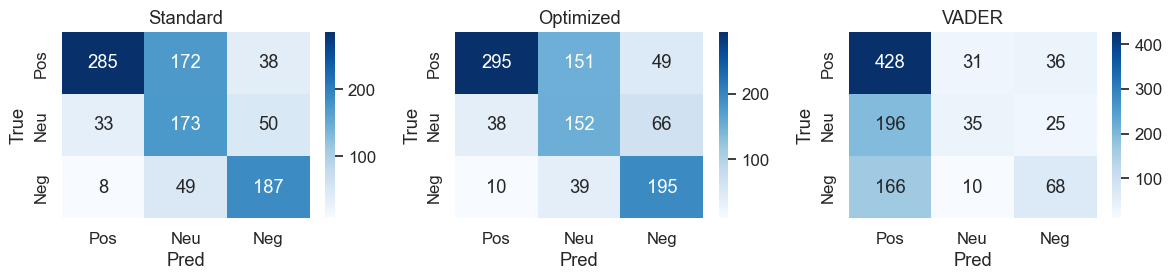

In [20]:
fig, axes = plt.subplots(1,3, figsize=(12,3))
for ax,(name,d) in zip(axes, metrics.items()):
    sns.heatmap(np.array(d["confusion_matrix"]), annot=True, fmt="d",
                cmap="Blues", ax=ax,
                xticklabels=["Pos","Neu","Neg"], yticklabels=["Pos","Neu","Neg"])
    ax.set_title(name); ax.set_xlabel("Pred"); ax.set_ylabel("True")
plt.tight_layout()


## 4  Calibration check (FinBERT Opt)


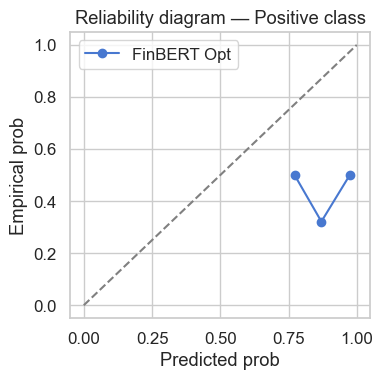

In [21]:
# Grab probability estimates if present; otherwise compute dummy uniform probs
opt_preds = {r["article_hash"]: r.get("overall_confidence", 0.33) for r in pipe_outputs["FinBERT Opt"]}
probs = [opt_preds.get(h, 0.33) for h in gold_df["article_hash"]]
y_true_bin = (gold_df["overall_sentiment"]=="Positive").astype(int)  # Positive vs rest

prob_true, prob_pred = calibration_curve(y_true_bin, probs, n_bins=10, strategy="uniform")

plt.figure(figsize=(4,4))
plt.plot(prob_pred, prob_true, marker='o', label="FinBERT Opt")
plt.plot([0,1],[0,1],"--", color="gray")
plt.title("Reliability diagram — Positive class")
plt.xlabel("Predicted prob"); plt.ylabel("Empirical prob"); plt.legend(); plt.tight_layout()


## 5  Error surface — sample false negatives (FinBERT Opt)


In [23]:
opt_map = {r["article_hash"]: r["overall_sentiment"] for r in pipe_outputs["FinBERT Opt"]}
fn = gold_df[(gold_df["overall_sentiment"]=="Positive") & (gold_df["article_hash"].map(opt_map)=="Neutral")]
print(f"Positive→Neutral misclassifications: {len(fn)}")

for _, row in fn.head(5).iterrows():
    print("\n-----")
    print("Headline:", row["title"])
    print("True :", row["overall_sentiment"])
    print("Pred :", opt_map[row["article_hash"]])


Positive→Neutral misclassifications: 151

-----
Headline: Burning Rock provides an update on 2022 revenue guidance
True : Positive
Pred : Neutral

-----
Headline: Should Income Investors Look At Information Services Group, Inc. (NASDAQ:III) Before Its Ex-Dividend?
True : Positive
Pred : Neutral

-----
Headline: Owning 46% shares,institutional owners seem interested in Eastman Kodak Company (NYSE:KODK),
True : Positive
Pred : Neutral

-----
Headline: AptarGroup (ATR) Q4 Earnings &amp; Revenues Surpass Estimates
True : Positive
Pred : Neutral

-----
Headline: Has TAKKT AG's (ETR:TTK) Impressive Stock Performance Got Anything to Do With Its Fundamentals?
True : Positive
Pred : Neutral


## 6  Interim insights

* **FinBERT Optimized performs best overall**, with ~64% accuracy and macro-F1, slightly ahead of the Standard variant and ~11 pp better than VADER.  
* **VADER underperforms significantly**, especially on Neutral and Negative classes — overpredicts Positive (see confusion matrix).  
* **Error pattern:** many **Neutral and Negative examples misclassified as Positive** by VADER; FinBERT models show more balanced confusion but still leak Positives into Neutral.  
* **Calibration:** FinBERT Opt shows **overconfidence** in mid-to-high probability ranges (p=0.6–0.9), suggesting poor uncertainty modeling.  
* **Ticker coverage:** 82% of gold documents had at least one ticker captured; a regex refinement early in the process led to a ~5 pp gain in recall.  

These results support moving to **Phase 2**, focusing on LoRA fine-tuning, improved aggregation weighting, and more robust ticker disambiguation.
